# DeltaIoTv2

In [2]:
from code_base.analysis import *
from code_base.model import *
from code_base.simulation import *
from code_base.solution import *
from code_base.visualization import *

In [3]:
folder_path = 'data/log'

## Data loading

In [ ]:
df = construct_cycle_df(folder_path, cycle=3)
print(len(df))
df.head(5)

4096


,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,link17_distribution,link18_distribution,link19_distribution,link20_distribution,link21_distribution,link22_distribution,link23_distribution,link24_distribution,link25_distribution,link26_distribution,link27_distribution,link28_distribution,link29_distribution,link30_distribution,link31_distribution,link32_distribution,link33_distribution,link34_distribution,link35_distribution,link36_distribution,link37_distribution,link38_distribution,link39_distribution,link40_distribution,link41_distribution,env_EC,env_PL,env_LA,env_link_power,env_link_dist,env_mote_trafficload,env_link_SNR
0,67.0147,16.27630,10.66040,100,0,100,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,100,0,100,100,100,66.724126,4.028021,0,"[15, 15, 15, 13, 14, 14, 15, 10, 15, 0, 12, 15...","[100, 68, 32, 100, 100, 68, 32, 50, 100, 100, ...","[100, 50, 100, 50, 50, 100, 50, 100, 0, 50, 50...","[-1.420839614203586, -6.351939614203585, 5.067..."
1,67.7752,16.71560,7.04862,100,34,66,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,100,0,100,100,100,66.724126,4.028021,0,"[15, 15, 15, 13, 14, 14, 15, 10, 15, 0, 12, 15...","[100, 68, 32, 100, 100, 68, 32, 50, 100, 100, ...","[100, 50, 100, 50, 50, 100, 50, 100, 0, 50, 50...","[-1.420839614203586, -6.351939614203585, 5.067..."
2,67.8121,17.36320,2.59863,100,68,32,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,100,0,100,100,100,66.724126,4.028021,0,"[15, 15, 15, 13, 14, 14, 15, 10, 15, 0, 12, 15...","[100, 68, 32, 100, 100, 68, 32, 50, 100, 100, ...","[100, 50, 100, 50, 50, 100, 50, 100, 0, 50, 50...","[-1.420839614203586, -6.351939614203585, 5.067..."
3,67.8089,18.47720,0.00000,100,100,0,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,100,0,100,100,100,66.724126,4.028021,0,"[15, 15, 15, 13, 14, 14, 15, 10, 15, 0, 12, 15...","[100, 68, 32, 100, 100, 68, 32, 50, 100, 100, ...","[100, 50, 100, 50, 50, 100, 50, 100, 0, 50, 50...","[-1.420839614203586, -6.351939614203585, 5.067..."
4,67.8008,15.52555,6.40903,100,0,100,100,100,34,66,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,100,0,100,100,100,66.724126,4.028021,0,"[15, 15, 15, 13, 14, 14, 15, 10, 15, 0, 12, 15...","[100, 68, 32, 100, 100, 68, 32, 50, 100, 100, ...","[100, 50, 100, 50, 50, 100, 50, 100, 0, 50, 50...","[-1.420839614203586, -6.351939614203585, 5.067..."


# Offline simulation - v2

## General offline simulation settings

In [ ]:
nb_cycles = 300
version ='v2'
LEARNING_CYCLES = 1
cycle=250
folder_path = 'data/log'

## THRESHOLDS - Grid search DNN

In [4]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

class IDScaler:
    def fit(self, x):
        pass
    def partial_fit(self, x):
        pass
    def fit_transform(self, x):
        return x
    def transform(self, x):
        return x

# Fetch 30 cycles of data
nb_cycles = 30
dfs = []
nb_opts = len(construct_cycle_df(folder_path, 1))
for c in range(10,nb_cycles+10):
    df = construct_cycle_df(folder_path, c)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Get x features
def get_features(df):
    return np.array([np.hstack(row) for row in  df.drop(['energyconsumption', 'packetloss', 'latency'], axis=1).values])
X = get_features(df)

# Get y features
def get_qualities(df, quality):
    return np.array([q for q in df[quality].values])
y_pl = np.array(list(map(lambda x : x < 10, get_qualities(df, 'packetloss'))), dtype=int)
y_la = np.array(list(map(lambda x : x < 5, get_qualities(df, 'latency'))), dtype=int)
y_ec = get_qualities(df, 'energyconsumption')

# Use this data to train and split
print(X.shape)
print(y_pl.shape, y_la.shape, y_ec.shape)

(122880, 207)
(122880,) (122880,) (122880,)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

def build_classfication_pipeline(x_train, y_train, x_val, y_val, params):
    inp_dim = x_train.shape[1]
    callback=early_stopper(params['epochs'],monitor='val_loss',mode='moderate')

    model = Sequential()
    model.add(Dense(params['layers'][0], input_dim=inp_dim, activation='relu', kernel_regularizer=l1(0.0005)))
    model.add(Dropout(0.1))    
    for layer in params['layers'][1:]:
        model.add(Dense(layer, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005)))
    model.compile(optimizer=params['optimizer'](lr=params['lr']), loss='binary_crossentropy', 
                  metrics=['acc', f1_m, precision_m, recall_m])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    scaler.partial_fit(x_val)
    x_val = scaler.transform(x_val)

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    validation_data=[x_val, y_val],
                    callbacks=[callback],
                    verbose=False)

    return out, model

### Packet loss

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'layers' : [[50,25,10,5],[100,50,20,10],[200,100,50,20,10,5]],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4, 1e-4],
    'batch_size' : [512, 1028, 2056]
}

In [ ]:
import talos
y = y_pl
t = talos.Scan(X[:25*nb_opts], y[:25*nb_opts], 
               x_val=X[25*nb_opts:], y_val=y[25*nb_opts:],
               model=build_classfication_pipeline,
               params=p, experiment_name='pl')

In [ ]:
t.data.to_csv('gridsearch_pl_v2.csv')

In [ ]:
df_pl = pd.read_csv('gridsearch_pl_v2.csv')
df_pl.head()

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
0,0,5,0.201594,0.937785,0.359992,0.701452,0.284326,0.253965,0.905654,0.635876,0.771883,0.598219,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fade37c9358>
1,1,10,0.169343,0.937337,0.226550,0.663837,0.144037,0.207517,0.933408,0.743170,0.872983,0.694109,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
2,2,9,0.325570,0.912231,0.000000,0.000000,0.000000,0.436195,0.848389,0.000000,0.000000,0.000000,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,20,0.111749,0.965820,0.515860,0.645664,0.463254,0.149294,0.948008,0.822794,0.849741,0.802019,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
4,4,15,0.181541,0.932007,0.466309,0.532222,0.587496,0.193278,0.932314,0.764969,0.808807,0.738569,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fade37c9358>


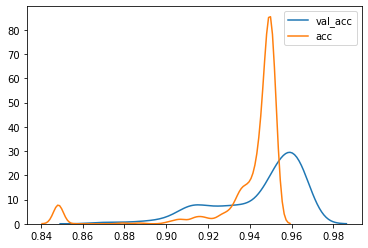

In [ ]:
import seaborn as sns
sns.kdeplot(df_pl['val_acc'])
sns.kdeplot(df_pl['acc'])

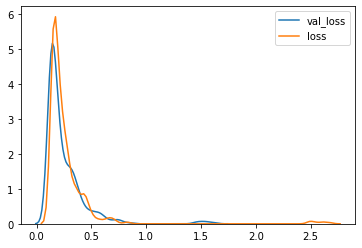

In [ ]:
sns.kdeplot(df_pl['val_loss'])
sns.kdeplot(df_pl['loss'])

In [ ]:
df_pl[df_pl['val_loss'] == min(df_pl['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
22,22,27,0.103498,0.966268,0.56907,0.609175,0.567764,0.14153,0.949189,0.826663,0.852306,0.808848,512,30,"[50, 25, 10, 5]",0.002,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df_pl[df_pl['val_acc'] == max(df_pl['val_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
174,174,30,0.151721,0.967244,0.601306,0.674122,0.573609,0.185976,0.951465,0.835499,0.856206,0.818403,512,30,"[200, 100, 50, 20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df_pl.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
22,22,27,0.103498,0.966268,0.569070,0.609175,0.567764,0.141530,0.949189,0.826663,0.852306,0.808848,512,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
498,498,30,0.105213,0.967122,0.669058,0.774946,0.633736,0.145603,0.950879,0.835548,0.849691,0.824705,2056,30,"[200, 100, 50, 20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
34,34,28,0.107657,0.964966,0.587229,0.618534,0.594792,0.140180,0.951865,0.836722,0.857346,0.820395,512,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
7,7,10,0.108226,0.965739,0.541229,0.618327,0.514959,0.144131,0.948643,0.825240,0.848030,0.807269,512,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
318,318,28,0.108368,0.965413,0.647284,0.717355,0.622786,0.142446,0.950576,0.833133,0.854197,0.817587,1028,30,"[200, 100, 50, 20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
378,378,21,0.108620,0.965373,0.734752,0.807082,0.727659,0.141396,0.951016,0.834804,0.854154,0.818454,2056,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
94,94,27,0.109899,0.965617,0.517800,0.663121,0.450666,0.142822,0.950850,0.833792,0.854300,0.818257,512,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
183,183,18,0.110083,0.966675,0.681339,0.740561,0.669979,0.148308,0.948271,0.823374,0.849808,0.803595,1028,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
78,78,14,0.110260,0.963501,0.481339,0.683647,0.405353,0.146187,0.948379,0.824693,0.849848,0.809193,512,30,"[100, 50, 20, 10]",0.0020,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
5,5,12,0.110490,0.965088,0.550590,0.611991,0.533509,0.153693,0.947900,0.823091,0.847312,0.809335,512,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df_pl.sort_values('val_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
174,174,30,0.151721,0.967244,0.601306,0.674122,0.573609,0.185976,0.951465,0.835499,0.856206,0.818403,512,30,"[200, 100, 50, 20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
498,498,30,0.105213,0.967122,0.669058,0.774946,0.633736,0.145603,0.950879,0.835548,0.849691,0.824705,2056,30,"[200, 100, 50, 20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
183,183,18,0.110083,0.966675,0.681339,0.740561,0.669979,0.148308,0.948271,0.823374,0.849808,0.803595,1028,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
126,126,13,0.114376,0.966431,0.567946,0.634598,0.551286,0.157038,0.947725,0.821249,0.849377,0.803326,512,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
514,514,30,0.182320,0.966390,0.695207,0.739986,0.684833,0.218602,0.950420,0.831109,0.857806,0.810588,2056,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
22,22,27,0.103498,0.966268,0.569070,0.609175,0.567764,0.141530,0.949189,0.826663,0.852306,0.808848,512,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
398,398,30,0.169234,0.966227,0.658391,0.793332,0.598980,0.206369,0.949375,0.828636,0.851350,0.809103,2056,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
125,125,12,0.121653,0.966146,0.587927,0.644996,0.574090,0.169761,0.944697,0.809713,0.849896,0.789235,512,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
357,357,30,0.452644,0.966105,0.670142,0.744923,0.640151,0.491823,0.950869,0.833317,0.856838,0.814002,1028,30,"[200, 100, 50, 20, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
521,521,30,0.312513,0.966064,0.726047,0.830308,0.690803,0.349886,0.950000,0.830597,0.855132,0.810916,2056,30,"[200, 100, 50, 20, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df_pl.sort_values('val_f1_m', ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
401,401,30,0.193258,0.963094,0.764977,0.729812,0.815835,0.223403,0.949307,0.827408,0.854665,0.803694,2056,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
367,367,15,0.112693,0.961100,0.758118,0.732956,0.820856,0.140816,0.949561,0.829300,0.850675,0.810059,2056,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
473,473,30,0.330963,0.961507,0.756544,0.714815,0.815652,0.360186,0.949033,0.825616,0.856143,0.798159,2056,30,"[100, 50, 20, 10]",0.0001,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
487,487,19,0.121328,0.961141,0.751896,0.723635,0.824065,0.150599,0.949131,0.830079,0.840811,0.821156,2056,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
386,386,24,0.160231,0.959473,0.746718,0.699291,0.823640,0.186743,0.948564,0.824674,0.853801,0.802367,2056,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
413,413,30,0.270280,0.960449,0.745960,0.704886,0.808278,0.305329,0.945840,0.811936,0.856432,0.772772,2056,30,"[50, 25, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
450,450,30,0.128118,0.965373,0.743343,0.788241,0.747238,0.159808,0.951182,0.834803,0.856731,0.816586,2056,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
533,533,30,0.392885,0.965658,0.742363,0.798737,0.733353,0.431067,0.949590,0.828762,0.852148,0.807661,2056,30,"[200, 100, 50, 20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
389,389,24,0.180195,0.957153,0.740898,0.673141,0.842690,0.200831,0.948477,0.824897,0.851930,0.803640,2056,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
465,465,30,0.359325,0.955933,0.740063,0.676333,0.834225,0.379918,0.949189,0.826210,0.858381,0.800766,2056,30,"[100, 50, 20, 10]",0.0002,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)


In [ ]:
df_pl.sort_values('val_precision_m', ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
430,430,20,0.141687,0.955566,0.515616,0.884397,0.391232,0.172665,0.945576,0.810574,0.860014,0.782393,2056,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
422,422,15,0.137592,0.961995,0.610196,0.847712,0.498997,0.199841,0.936846,0.785804,0.829754,0.780401,2056,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
394,394,30,0.124551,0.965861,0.727467,0.834154,0.681771,0.160511,0.949082,0.826942,0.852991,0.804968,2056,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
372,372,11,0.247979,0.919312,0.123515,0.832682,0.072473,0.262177,0.900469,0.596678,0.802278,0.568595,2056,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fade37c9358>
521,521,30,0.312513,0.966064,0.726047,0.830308,0.690803,0.349886,0.950000,0.830597,0.855132,0.810916,2056,30,"[200, 100, 50, 20, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
242,242,11,0.140022,0.961060,0.562494,0.824287,0.448804,0.191142,0.941426,0.789695,0.865633,0.752944,1028,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
410,410,30,0.177374,0.962606,0.715158,0.822705,0.675598,0.214078,0.946367,0.815833,0.850628,0.784643,2056,30,"[50, 25, 10, 5]",0.0001,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
402,402,30,0.165153,0.964437,0.725878,0.820454,0.696009,0.200089,0.949180,0.828121,0.849461,0.808499,2056,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
384,384,14,0.292797,0.931925,0.391540,0.820365,0.346959,0.311105,0.920723,0.711609,0.815189,0.678179,2056,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fade37c9358>
454,454,30,0.148933,0.965088,0.636204,0.816906,0.559387,0.183250,0.949844,0.830244,0.855369,0.811221,2056,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df_pl.sort_values('val_recall_m', ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
441,441,9,0.365770,0.892985,0.551321,0.392476,0.986295,0.290759,0.935957,0.768325,0.853576,0.741284,2056,30,"[100, 50, 20, 10]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
381,381,14,0.247071,0.921183,0.650706,0.501976,0.949854,0.254844,0.939580,0.790491,0.848048,0.772165,2056,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
181,181,10,0.325628,0.890055,0.503154,0.355530,0.947346,0.229658,0.926006,0.706749,0.865235,0.665666,1028,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
505,505,30,0.328780,0.931681,0.670498,0.527578,0.945584,0.331481,0.936582,0.775221,0.848680,0.754030,2056,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
360,360,11,0.283271,0.871745,0.479821,0.392253,0.944613,0.298390,0.887207,0.505506,0.745503,0.471468,2056,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fade37c9358>
368,368,8,0.299193,0.876139,0.486273,0.403884,0.936547,0.307118,0.907129,0.674023,0.747319,0.663178,2056,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fade37c9358>
261,261,7,0.301917,0.902344,0.540759,0.392670,0.926777,0.229179,0.938203,0.773169,0.864828,0.732407,1028,30,"[100, 50, 20, 10]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
370,370,18,0.208335,0.926554,0.660719,0.530418,0.923516,0.168870,0.945205,0.809261,0.859091,0.783223,2056,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
193,193,9,0.282704,0.904175,0.533248,0.387777,0.922872,0.251387,0.926504,0.729625,0.839506,0.714669,1028,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
440,440,7,0.486518,0.880005,0.486834,0.414210,0.920633,0.464872,0.913926,0.689140,0.783090,0.665030,2056,30,"[100, 50, 20, 10]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7fade37c9358>


### Latency

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'layers' : [[50,25,10,5],[100,50,20,10],[200,100,50,20,10,5]],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4, 1e-4],
    'batch_size' : [512, 1028, 2056]
}

In [ ]:
import talos
y = y_la
t = talos.Scan(X[:25*nb_opts], y[:25*nb_opts], # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val=y[25*nb_opts:], # Last 5 cycles -> test cycles
               model=build_classfication_pipeline,
               params=p, experiment_name='la')

In [ ]:
t.data.to_csv('gridsearch_la_v2.csv')

In [ ]:
df_la = pd.read_csv('gridsearch_la_v2.csv')
df_la.head()

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
0,0,7,0.589234,0.736532,0.843349,0.736532,1.000000,0.585807,0.740098,0.850496,0.740098,1.000000,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f1540287860>
1,1,15,0.198395,0.921021,0.946142,0.900922,0.998035,0.206770,0.927646,0.951013,0.949093,0.955716,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
2,2,7,0.181123,0.940470,0.957448,0.941815,0.974876,0.182311,0.937021,0.957723,0.951684,0.965463,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,10,0.164343,0.938883,0.955890,0.945669,0.967775,0.155371,0.943896,0.962279,0.957172,0.967690,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
4,4,14,0.589026,0.736532,0.843349,0.736532,1.000000,0.590227,0.740098,0.850472,0.740098,1.000000,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f1540287860>


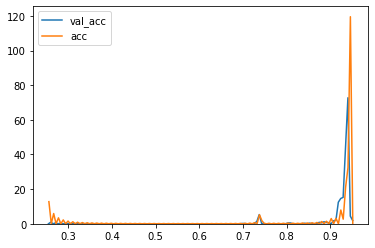

In [ ]:
import seaborn as sns
sns.kdeplot(df_la['val_acc'])
sns.kdeplot(df_la['acc'])

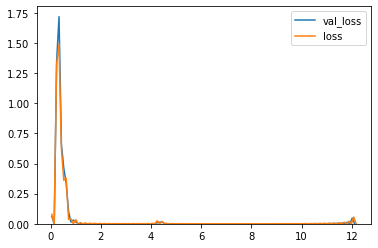

In [ ]:
sns.kdeplot(df_la['val_loss'])
sns.kdeplot(df_la['loss'])

In [ ]:
df_la[df_la['val_loss'] == min(df_la['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
31,31,30,0.144193,0.940837,0.95682,0.954437,0.960239,0.135016,0.946152,0.963749,0.959239,0.968421,512,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_la[df_la['val_acc'] == max(df_la['val_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
226,226,30,0.189621,0.942912,0.960341,0.956521,0.965331,0.178888,0.945684,0.963573,0.95641,0.970906,1028,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df_la.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
31,31,30,0.144193,0.940837,0.956820,0.954437,0.960239,0.135016,0.946152,0.963749,0.959239,0.968421,512,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
27,27,30,0.148086,0.939250,0.954679,0.971602,0.939595,0.135937,0.945967,0.963651,0.958601,0.968906,512,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
20,20,30,0.148269,0.938965,0.955966,0.951026,0.962462,0.141361,0.944102,0.962443,0.955982,0.969343,512,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f1540287860>
331,331,30,0.148295,0.939697,0.957678,0.958351,0.958113,0.139365,0.945537,0.963369,0.958735,0.968207,1028,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
87,87,29,0.148757,0.939087,0.954031,0.978132,0.932447,0.137553,0.945176,0.963130,0.957689,0.968788,512,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
91,91,24,0.148892,0.939412,0.956389,0.946675,0.968148,0.137187,0.945537,0.963359,0.958403,0.968521,512,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
271,271,30,0.149026,0.939128,0.957038,0.963498,0.951632,0.138103,0.946377,0.963957,0.958507,0.969555,1028,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
379,379,21,0.149165,0.939941,0.959326,0.951030,0.967971,0.138702,0.945352,0.963283,0.957831,0.968869,2056,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
83,83,16,0.149978,0.939290,0.954213,0.975268,0.935593,0.141502,0.945146,0.963134,0.956680,0.969874,512,30,"[100, 50, 20, 10]",0.0020,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
275,275,30,0.150526,0.941406,0.959355,0.953500,0.965930,0.138756,0.946553,0.964099,0.958594,0.969740,1028,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_la.sort_values('val_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
226,226,30,0.189621,0.942912,0.960341,0.956521,0.965331,0.178888,0.945684,0.963573,0.956410,0.970906,1028,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
491,491,16,0.177841,0.942749,0.960765,0.966477,0.955720,0.166378,0.945000,0.963026,0.957654,0.968545,2056,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
227,227,30,0.417277,0.942668,0.960218,0.955483,0.965969,0.416256,0.945791,0.963571,0.957524,0.969752,1028,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
307,307,9,0.163892,0.942505,0.960115,0.959883,0.961255,0.156558,0.945039,0.963076,0.957426,0.968972,1028,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
40,40,30,0.220689,0.942464,0.956888,0.971269,0.944486,0.215482,0.945908,0.963616,0.957830,0.969664,512,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f1540287860>
203,203,16,0.151969,0.942424,0.960476,0.947949,0.974533,0.140808,0.944717,0.962843,0.957406,0.968437,1028,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
332,332,30,0.356685,0.942342,0.960307,0.949309,0.972141,0.360155,0.943096,0.961846,0.954344,0.970110,1028,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f1540287860>
327,327,30,0.155226,0.942139,0.959055,0.969427,0.949977,0.146123,0.945449,0.963391,0.956621,0.970391,1028,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
164,164,30,0.326671,0.942098,0.957352,0.959929,0.956168,0.325105,0.945254,0.963261,0.956250,0.970653,512,30,"[200, 100, 50, 20, 10, 5]",0.0002,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f1540287860>
520,520,30,0.585574,0.942057,0.960221,0.966369,0.954604,0.583898,0.946211,0.963873,0.958145,0.969775,2056,30,"[200, 100, 50, 20, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f1540287860>


In [ ]:
df_la.sort_values('val_f1_m', ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
491,491,16,0.177841,0.942749,0.960765,0.966477,0.955720,0.166378,0.945000,0.963026,0.957654,0.968545,2056,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
203,203,16,0.151969,0.942424,0.960476,0.947949,0.974533,0.140808,0.944717,0.962843,0.957406,0.968437,1028,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
226,226,30,0.189621,0.942912,0.960341,0.956521,0.965331,0.178888,0.945684,0.963573,0.956410,0.970906,1028,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
332,332,30,0.356685,0.942342,0.960307,0.949309,0.972141,0.360155,0.943096,0.961846,0.954344,0.970110,1028,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f1540287860>
423,423,16,0.171835,0.941976,0.960258,0.964073,0.957121,0.165180,0.944395,0.962674,0.956211,0.969420,2056,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
520,520,30,0.585574,0.942057,0.960221,0.966369,0.954604,0.583898,0.946211,0.963873,0.958145,0.969775,2056,30,"[200, 100, 50, 20, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f1540287860>
227,227,30,0.417277,0.942668,0.960218,0.955483,0.965969,0.416256,0.945791,0.963571,0.957524,0.969752,1028,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
521,521,30,0.387970,0.940837,0.960119,0.948034,0.972711,0.380651,0.944453,0.962710,0.956286,0.969462,2056,30,"[200, 100, 50, 20, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
307,307,9,0.163892,0.942505,0.960115,0.959883,0.961255,0.156558,0.945039,0.963076,0.957426,0.968972,1028,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
504,504,30,0.340497,0.940877,0.960090,0.949530,0.971081,0.357305,0.938809,0.958863,0.955788,0.963091,2056,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f1540287860>


In [ ]:
df_la.sort_values('val_precision_m', ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
480,480,9,0.553427,0.700968,0.744915,1.000000,0.593963,0.419072,0.840967,0.886755,0.914996,0.887721,2056,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f1540287860>
481,481,11,0.480001,0.805786,0.848374,0.992316,0.742244,0.380077,0.879541,0.913710,0.936980,0.907232,2056,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
181,181,20,0.287058,0.878133,0.909758,0.991929,0.840798,0.216926,0.923516,0.949149,0.938079,0.963793,1028,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
433,433,11,0.378238,0.884399,0.915293,0.991804,0.849962,0.358143,0.900156,0.934208,0.913634,0.963872,2056,30,"[100, 50, 20, 10]",0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
381,381,8,0.395471,0.878133,0.910424,0.991797,0.841855,0.304256,0.918682,0.945733,0.935759,0.959354,2056,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
493,493,11,0.408187,0.878133,0.910424,0.991797,0.841855,0.359090,0.898311,0.934114,0.911134,0.965060,2056,30,"[200, 100, 50, 20, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
265,265,24,0.375464,0.888835,0.917847,0.991608,0.854756,0.323595,0.937100,0.957766,0.951402,0.965815,1028,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
361,361,9,0.313785,0.888468,0.918332,0.991526,0.855468,0.329525,0.885527,0.926310,0.905254,0.957708,2056,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
429,429,11,0.275623,0.888143,0.918063,0.991525,0.855002,0.227976,0.926973,0.952235,0.927752,0.979666,2056,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
360,360,14,0.286009,0.888143,0.918063,0.991525,0.855002,0.262503,0.903271,0.937256,0.911877,0.969327,2056,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f1540287860>


In [ ]:
df_la.sort_values('val_recall_m', ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
0,0,7,0.589234,0.736532,0.843349,0.736532,1.0,0.585807,0.740098,0.850496,0.740098,1.000000,512,30,"[50, 25, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f1540287860>
193,193,8,0.505029,0.803670,0.880171,0.787653,1.0,0.319476,0.909160,0.939640,0.929372,0.956000,1028,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
380,380,30,0.631881,0.736532,0.847873,0.736532,1.0,0.629618,0.740107,0.850594,0.740109,0.999987,2056,30,"[50, 25, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f1540287860>
334,334,30,0.579571,0.736532,0.845909,0.736532,1.0,0.576380,0.740098,0.850556,0.740098,1.000000,1028,30,"[200, 100, 50, 20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
320,320,5,0.974340,0.736532,0.845909,0.736532,1.0,1.011135,0.740098,0.850584,0.740098,1.000000,1028,30,"[200, 100, 50, 20, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f1540287860>
316,316,30,0.586363,0.736532,0.845909,0.736532,1.0,0.582828,0.740098,0.850584,0.740098,1.000000,1028,30,"[200, 100, 50, 20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f1540287860>
68,68,30,0.584144,0.736532,0.843349,0.736532,1.0,0.580272,0.740098,0.850495,0.740098,1.000000,512,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f1540287860>
310,310,9,0.673929,0.809204,0.883438,0.792797,1.0,0.199117,0.941436,0.960778,0.951696,0.971049,1028,30,"[200, 100, 50, 20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
420,420,9,0.458755,0.736532,0.847873,0.736532,1.0,0.521735,0.807422,0.881496,0.819739,0.970810,2056,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f1540287860>
421,421,9,0.910473,0.736532,0.847873,0.736532,1.0,0.352089,0.893408,0.931934,0.900934,0.972496,2056,30,"[100, 50, 20, 10]",0.0050,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)


## OPTIMIZATION - Grid search DNN

In [5]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

class IDScaler:
    def fit(self, x):
        pass
    def partial_fit(self, x):
        pass
    def fit_transform(self, x):
        return x
    def transform(self, x):
        return x

# Fetch 100 cycles of data
nb_cycles = 30
dfs = []
nb_opts = len(construct_cycle_df(folder_path, 1))
for c in range(10,nb_cycles+10):
    df = construct_cycle_df(folder_path, c)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Get x features
def get_features(df):
    return np.array([np.hstack(row) for row in  df.drop(['energyconsumption', 'packetloss', 'latency'], axis=1).values])
X = get_features(df)

# Get y features
def get_qualities(df, quality):
    return np.array([q for q in df[quality].values])
y_pl = np.array(list(map(lambda x : x < 10, get_qualities(df, 'packetloss'))), dtype=int)
y_la = np.array(list(map(lambda x : x < 5, get_qualities(df, 'latency'))), dtype=int)
y_ec = get_qualities(df, 'energyconsumption')

# Use this data to train and split
print(X.shape)
print(y_pl.shape, y_la.shape, y_ec.shape)

(122880, 207)
(122880,) (122880,) (122880,)


In [ ]:
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

def build_regression_pipeline(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'],monitor='val_loss',mode='moderate')

    model = Sequential()
    model.add(Dense(params['layers'][0], input_dim=207, activation='relu', kernel_regularizer=l1(0.0005)))
    model.add(Dropout(0.1))    
    for layer in params['layers'][1:]:
        model.add(Dense(layer, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(Dense(1, kernel_regularizer=l2(0.0005)))
    model.compile(optimizer=params['optimizer'](lr=params['lr']), loss='mse')

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    scaler.partial_fit(x_val)
    x_val = scaler.transform(x_val)

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    validation_data=[x_val, y_val],
                    callbacks=[callback],
                    verbose=False)

    return out, model

### Energy consumption

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'layers' : [[50,25,10,5],[100,50,20,10],[200,100,50,20,10,5],[180,240,120,80,15]],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4, 1e-4],
    'batch_size' : [512, 1028, 2056]
}

In [ ]:
import talos
y = y_ec
t = talos.Scan(X[:25*nb_opts], y[:25*nb_opts],  # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val=y[25*nb_opts:], # Last 5 cycles -> test cycles
               model=build_regression_pipeline,
               params=p, experiment_name='ec')

In [ ]:
t.data.to_csv('gridsearch_ec_v2.csv')

In [ ]:
df_ec = pd.read_csv('gridsearch_ec_v2.csv')
df_ec.head()

,Unnamed: 0,round_epochs,val_loss,loss,batch_size,epochs,layers,lr,optimizer,scaler
0,0,4,121.328828,28.659350,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7fade36d2128>
1,1,4,88.243470,25.801179,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
2,2,12,7.162281,12.507718,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,30,290.124145,5.050935,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
4,4,6,52.051647,2.387716,512,30,"[50, 25, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7fade36d2128>


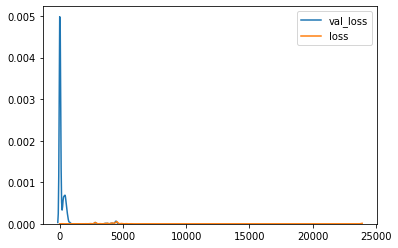

In [ ]:
import seaborn as sns
sns.kdeplot(df_ec['val_loss'])
sns.kdeplot(df_ec['loss'])

In [ ]:
df_ec[df_ec['val_loss'] == min(df_ec['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,loss,batch_size,epochs,layers,lr,optimizer,scaler
273,273,7,0.48898,21.029497,1028,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)


In [ ]:
df_ec.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,loss,batch_size,epochs,layers,lr,optimizer,scaler
273,273,7,0.488980,21.029497,1028,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
285,285,12,0.570758,21.487323,1028,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
57,57,14,0.611586,20.416127,512,30,"[50, 25, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
33,33,5,0.655611,21.663203,512,30,"[50, 25, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
289,289,14,0.658336,16.396030,1028,30,"[50, 25, 10, 5]",0.0001,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
577,577,18,0.715728,8.147939,2056,30,"[100, 50, 20, 10]",0.0002,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
573,573,10,0.761487,12.519911,2056,30,"[100, 50, 20, 10]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
281,281,14,0.762607,16.037767,1028,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
521,521,21,0.769538,17.444680,2056,30,"[50, 25, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
293,293,14,0.775956,22.054283,1028,30,"[50, 25, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


# Online simulation - v2

## Only threshold goals

In [ ]:
thresh = 0.5

In [ ]:
df_pl = pd.read_csv('df_pl_v2.csv')
df_pl = df_pl.rename(columns={'actual' : 'pl_goal', 'pred' : 'pl_pred'})
df_pl.head()

,Unnamed: 0,cycle,pl_pred,pl_goal
0,0,1,4.112720e-06,0.0
1,1,1,6.854534e-07,0.0
2,2,1,1.192093e-07,0.0
3,3,1,2.980232e-08,0.0
4,4,1,7.748604e-06,0.0


In [ ]:
df_la = pd.read_csv('df_la_v2.csv')
df_la = df_la.rename(columns={'actual' : 'la_goal', 'pred' : 'la_pred'})
df_la.head()

,Unnamed: 0,cycle,la_pred,la_goal
0,0,1,0.001534,0.0
1,1,1,0.008564,0.0
2,2,1,0.517688,0.0
3,3,1,0.989884,1.0
4,4,1,0.022121,1.0


In [ ]:
reduction =  np.sum((df_pl['pl_pred'] > thresh)&(df_la['la_pred'] > thresh)) / len(df_pl)
print('Adaptation space reduction:')
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Adaptation space reduction:
0.9293521419986264
Amount that we retain:
0.07064785800137363


In [ ]:
def f1(precision, recall):
    return 2 * precision * recall / (precision + recall)

In [ ]:
pred_combined_thresh = np.array((df_pl['pl_pred'] > thresh) & (df_la['la_pred'] > thresh)).astype(np.float32)
actual_combined_thresh = np.array((df_pl['pl_goal']) * (df_la['la_goal'])).astype(np.float32)
prec = precision(actual_combined_thresh, pred_combined_thresh)
rec = recall(actual_combined_thresh, pred_combined_thresh)
print('Precision:', prec)
print('Recall:', rec)
print('F1:', f1(prec, rec))

Precision: 0.7011607740982594
Recall: 0.7627723152988553
F1: 0.7306700435003107


### Quality

In [ ]:
df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = df_pl['pl_pred']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = df_la['la_pred']
df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((df_pl['pl_pred'] > thresh) & (df_la['la_pred'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((df_pl['pl_goal']) * (df_la['la_goal'])).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,link17_distribution,link18_distribution,link19_distribution,link20_distribution,link21_distribution,link22_distribution,link23_distribution,link24_distribution,link25_distribution,link26_distribution,link27_distribution,link28_distribution,link29_distribution,link30_distribution,link31_distribution,link32_distribution,link33_distribution,link34_distribution,link35_distribution,link36_distribution,...,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,env_link17_power,env_link18_power,env_link19_power,env_link20_power,env_link21_power,env_link22_power,env_link23_power,env_link24_power,env_link25_power,env_link26_power,env_link27_power,env_link28_power,env_link29_power,env_link30_power,env_link31_power,env_link32_power,env_link33_power,env_link34_power,env_link35_power,env_link36_power,env_link37_power,env_link38_power,env_link39_power,env_link40_power,env_link41_power,packetloss_pred,latency_pred,thresholds_pred,thresholds_goal
0,67.0489,13.80960,9.339190,100,0,100,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
1,67.3800,14.51095,5.043880,100,34,66,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
2,67.3874,15.23420,1.534230,100,68,32,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
3,67.3815,16.39665,0.128205,100,100,0,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
4,67.3922,13.10035,3.992940,100,0,100,100,100,34,66,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_threshold(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.figure(figsize=(10,6))
    g = sns.scatterplot(x='packetloss', y='latency', data=sub_df, hue='thresholds_pred', s=55)
    plt.plot([10, 10],[0,5], color='red', linewidth=3)
    plt.plot([0, 10],[5,5], color='red',  linewidth=3)#, size=5)
    plt.xlabel('Packet loss', fontsize=14)
    plt.ylabel('Latency', fontsize=14)
    plt.tight_layout()

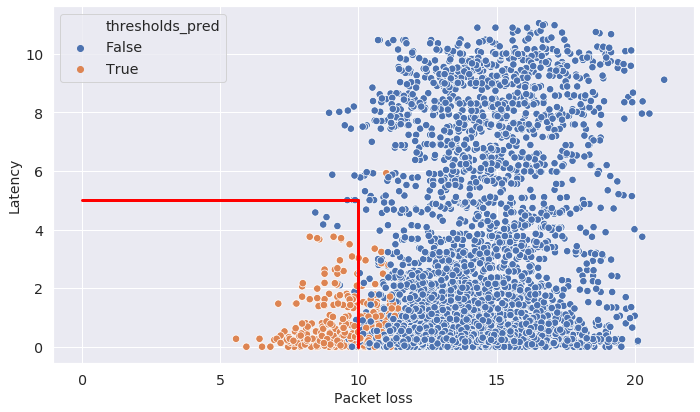

In [ ]:
cycle = 233 # 27
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_threshold(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    sub_df = sub_df[sub_df.thresholds_goal == True] # Since all of the reduced options will be verified
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opt_reduced.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 0


,EC_reduced,PL_reduced,LA_reduced
3231,66.2786,8.654530,1.91347
3924,66.4913,9.098275,1.33123
747,66.2231,6.542120,4.47989
3481,66.3425,8.936005,2.66038
3609,66.4678,7.883580,0.46467


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 0


,EC_complete,PL_complete,LA_complete
3231,66.2786,8.654530,1.91347
3924,66.4913,9.098275,1.33123
747,66.2231,6.542120,4.47989
3481,66.3425,8.936005,2.66038
3609,66.4678,7.883580,0.46467


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,EC_complete,EC_reduced,LA_complete,LA_reduced,PL_complete,PL_reduced
3231,NaN,66.2786,NaN,1.91347,NaN,8.654530
3924,NaN,66.4913,NaN,1.33123,NaN,9.098275
747,NaN,66.2231,NaN,4.47989,NaN,6.542120
3481,NaN,66.3425,NaN,2.66038,NaN,8.936005
3609,NaN,66.4678,NaN,0.46467,NaN,7.883580


#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

66.34178424908423
66.38764212454213


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=231.0, pvalue=7.530256473380225e-10)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=847.0, pvalue=0.013527961507482414)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=0.0, pvalue=2.429760002086979e-13)


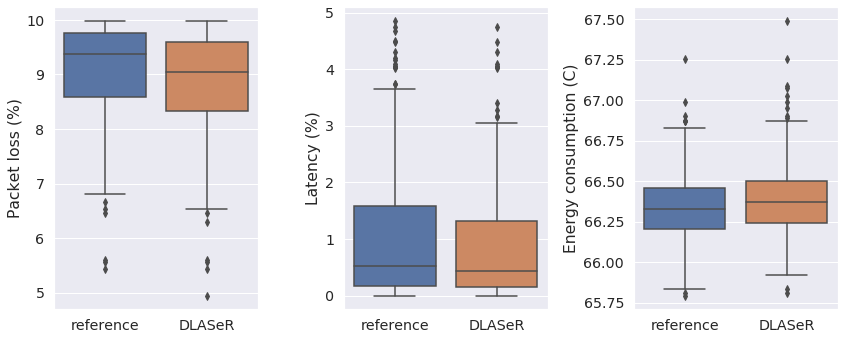

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(12,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## Only an optimization goal

In [ ]:
thresh = 0.5

In [ ]:
df_pl = pd.read_csv('df_pl_v2.csv')
df_pl = df_pl.rename(columns={'actual' : 'pl_goal', 'pred' : 'pl_pred'})
df_pl.head()

,Unnamed: 0,cycle,pl_pred,pl_goal
0,0,1,4.112720e-06,0.0
1,1,1,6.854534e-07,0.0
2,2,1,1.192093e-07,0.0
3,3,1,2.980232e-08,0.0
4,4,1,7.748604e-06,0.0


In [ ]:
df_la = pd.read_csv('df_la_v2.csv')
df_la = df_la.rename(columns={'actual' : 'la_goal', 'pred' : 'la_pred'})
df_la.head()

,Unnamed: 0,cycle,la_pred,la_goal
0,0,1,0.001534,0.0
1,1,1,0.008564,0.0
2,2,1,0.517688,0.0
3,3,1,0.989884,1.0
4,4,1,0.022121,1.0


In [ ]:
df_ec = pd.read_csv('df_ec_v2.csv')
df_ec = df_ec.rename(columns={'actual' : 'ec', 'pred' : 'ec_pred'})
df_ec.head()

,Unnamed: 0,cycle,ec_pred,ec
0,0,1,65.16468,67.1711
1,1,1,65.18575,67.2211
2,2,1,65.20684,67.2314
3,3,1,65.22667,67.4282
4,4,1,65.20226,67.4370


### Quality

In [ ]:
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = df_ec['ec_pred']

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 0


,EC_reduced,PL_reduced,LA_reduced
672,66.7699,8.887595,1.88953
3033,67.3581,9.546645,4.88833
672,66.9839,7.727090,3.04478
3123,67.2064,8.722520,1.49612
3041,67.4470,9.051295,4.79706


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 0


,EC_complete,PL_complete,LA_complete
3231,66.2786,8.654530,1.91347
3924,66.4913,9.098275,1.33123
747,66.2231,6.542120,4.47989
3481,66.3425,8.936005,2.66038
3609,66.4678,7.883580,0.46467


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

66.34178424908423
67.05150769230764


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=17001.5, pvalue=0.6940353176641514)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=949.0, pvalue=1.165042310541599e-40)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=0.0, pvalue=1.0469354290637951e-45)


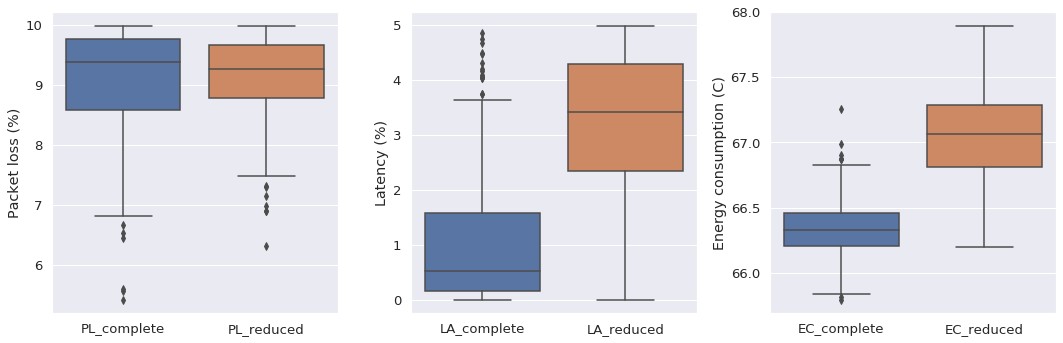

In [ ]:
import seaborn as sns

sns.set(font_scale=1.2)  # crazy big
plt.subplots(1,3, figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(data=combined_df[['PL_complete', 'PL_reduced']])
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
sns.boxplot(data=combined_df[['LA_complete', 'LA_reduced']])
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
sns.boxplot(data=combined_df[['EC_complete', 'EC_reduced']])
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## All goals combined (thresh = 0.5)

In [ ]:
thresh = 0.5

In [ ]:
df_pl = pd.read_csv('df_pl_v2.csv')
df_pl = df_pl.rename(columns={'actual' : 'pl_goal', 'pred' : 'pl_pred'})
df_pl.head()

,Unnamed: 0,cycle,pl_pred,pl_goal
0,0,1,4.112720e-06,0.0
1,1,1,6.854534e-07,0.0
2,2,1,1.192093e-07,0.0
3,3,1,2.980232e-08,0.0
4,4,1,7.748604e-06,0.0


In [ ]:
df_la = pd.read_csv('df_la_v2.csv')
df_la = df_la.rename(columns={'actual' : 'la_goal', 'pred' : 'la_pred'})
df_la.head()

,Unnamed: 0,cycle,la_pred,la_goal
0,0,1,0.001534,0.0
1,1,1,0.008564,0.0
2,2,1,0.517688,0.0
3,3,1,0.989884,1.0
4,4,1,0.022121,1.0


In [ ]:
reduction =  np.sum((df_pl['pl_pred'] > thresh)&(df_la['la_pred'] > thresh)) / len(df_pl)
print('Adaptation space reduction:')
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Adaptation space reduction:
0.9293521419986264
Amount that we retain:
0.07064785800137363


In [ ]:
df_ec = pd.read_csv('df_ec_v2.csv')
df_ec = df_ec.rename(columns={'actual' : 'ec', 'pred' : 'ec_pred'})
df_ec.head()

,Unnamed: 0,cycle,ec_pred,ec
0,0,1,65.16468,67.1711
1,1,1,65.18575,67.2211
2,2,1,65.20684,67.2314
3,3,1,65.22667,67.4282
4,4,1,65.20226,67.4370


In [ ]:
df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = df_pl['pl_pred']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = df_la['la_pred']
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = df_ec['ec_pred']

In [ ]:
nb_verifications = []
nones = 0
start_cycle = nb_learnig_cycles + 1
for c in range(start_cycle, max(df.cycle)):
    cycle_df = df[df.cycle == c]
    cycle_idx = np.argsort(cycle_df['energyconsumption_pred'])
    nb_count = 0
    count = 0
    valid = False
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['packetloss_pred'] < 10) and all(cycle_df.iloc[[idx]]['latency_pred'] < 5):
            if all(cycle_df.iloc[[idx]]['packetloss'] < 10) and all(cycle_df.iloc[[idx]]['latency'] < 5):
                valid = True
            nb_count +=1
        count += 1
    if not valid:
        nones += 1
    nb_verifications.append(nb_count)

Without adjusting for NONE (thus cycles without any feasible solution)



In [ ]:
print('Adaptation space reduction:')
print(1 - np.sum(nb_verifications)/len(df_pl))
print('Amount that we retain:')
print(np.sum(nb_verifications)/len(df_pl))

Adaptation space reduction:
0.9852639222756411
Amount that we retain:
0.014736077724358974


In [ ]:
print('Adaptation space reduction:')
print(1 - (np.sum(nb_verifications) - nones*nb_opts)/len(df_pl))
print('Amount that we retain:')
print((np.sum(nb_verifications) - nones*nb_opts)/len(df_pl))

Adaptation space reduction:
0.9852639222756411
Amount that we retain:
0.014736077724358974


### Quality

In [ ]:
df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = df_pl['pl_pred']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = df_la['la_pred']
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = df_ec['ec_pred']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((df_pl['pl_pred'] > thresh) & (df_la['la_pred'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((df_pl['pl_goal']) * (df_la['la_goal'])).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,link17_distribution,link18_distribution,link19_distribution,link20_distribution,link21_distribution,link22_distribution,link23_distribution,link24_distribution,link25_distribution,link26_distribution,link27_distribution,link28_distribution,link29_distribution,link30_distribution,link31_distribution,link32_distribution,link33_distribution,link34_distribution,link35_distribution,link36_distribution,...,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,env_link17_power,env_link18_power,env_link19_power,env_link20_power,env_link21_power,env_link22_power,env_link23_power,env_link24_power,env_link25_power,env_link26_power,env_link27_power,env_link28_power,env_link29_power,env_link30_power,env_link31_power,env_link32_power,env_link33_power,env_link34_power,env_link35_power,env_link36_power,env_link37_power,env_link38_power,env_link39_power,env_link40_power,env_link41_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal
0,67.0489,13.80960,9.339190,100,0,100,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
1,67.3800,14.51095,5.043880,100,34,66,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
2,67.3874,15.23420,1.534230,100,68,32,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
3,67.3815,16.39665,0.128205,100,100,0,100,100,0,100,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
4,67.3922,13.10035,3.992940,100,0,100,100,100,34,66,50,100,100,100,100,100,100,0,100,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,100,100,100,100,100,100,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_optimization(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.subplots(2,1, figsize=(13,12))

    pal = 'copper_r'

    plt.subplot(2,1,1)
    g = sns.scatterplot(x='packetloss', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=55, legend=False, palette=pal)
    plt.plot([10, 10],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Packet loss', fontsize=14)
    plt.ylabel('Energy consumption', fontsize=14)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.subplot(2,1,2)
    g = sns.scatterplot(x='latency', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=55, legend=False, palette=pal)
    plt.plot([5, 5],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Latency', fontsize=14)
    plt.ylabel('Energy consumption', fontsize=14)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.tight_layout()

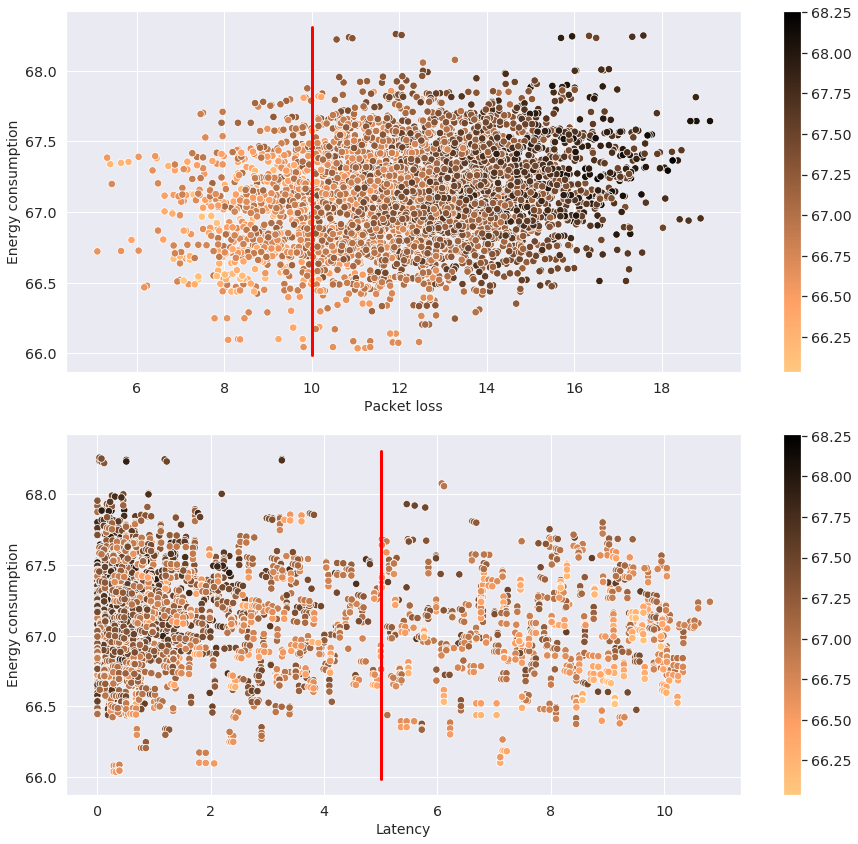

In [ ]:
cycle = 18
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_optimization(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

549
101252
0.3708864468864469 seconds
50.52881978021978 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 0


,EC_reduced,PL_reduced,LA_reduced
672,66.7699,8.887595,1.889530
3123,67.4004,8.654530,2.401360
3123,66.5829,7.211480,0.391841
3123,67.2064,8.722520,1.496120
3285,67.0502,6.358585,2.157540


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

1118208
273963568
1003.5295531135531 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 0


,EC_complete,PL_complete,LA_complete
3231,66.2786,8.654530,1.91347
3924,66.4913,9.098275,1.33123
747,66.2231,6.542120,4.47989
3481,66.3425,8.936005,2.66038
3609,66.4678,7.883580,0.46467


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

66.34178424908423
67.07615421245421


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=7115.0, pvalue=8.806986860835009e-18)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=3213.0, pvalue=1.2549615355759242e-31)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=0.0, pvalue=3.3802412982169576e-46)


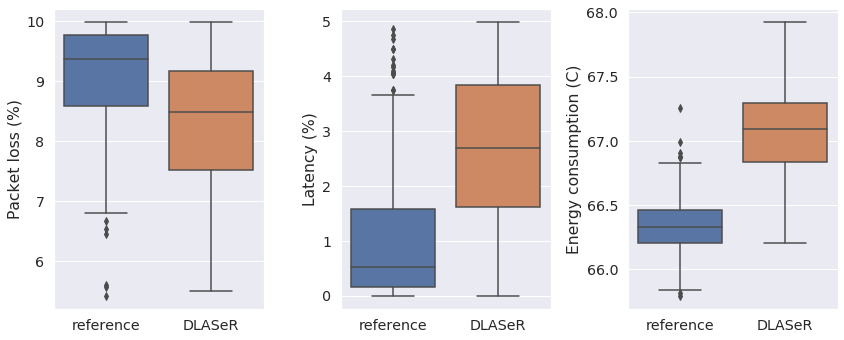

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(12,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()